In [1]:
import os
import keras
keras.__version__
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [3]:
def get_session():
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [4]:
keras.backend.tensorflow_backend.set_session(get_session())

# Directorios

In [5]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

# Modelo InceptionResNetV2

In [7]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

if multi_gpu > 1:  
    with tf.device('/cpu:0'):
        conv_base = InceptionResNetV2(weights='imagenet',
                                      include_top=False,
                                      input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.
219062272/219055592 [==============================] - 5s 0us/step


In [8]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

conv2d_137 (Conv2D)             (None, 17, 17, 192)  208896      block17_15_ac[0][0]              
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 17, 17, 192)  215040      activation_139[0][0]             
__________________________________________________________________________________________________
batch_normalization_137 (BatchN (None, 17, 17, 192)  576         conv2d_137[0][0]                 
__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 17, 17, 192)  576         conv2d_140[0][0]                 
__________________________________________________________________________________________________
activation_137 (Activation)     (None, 17, 17, 192)  0           batch_normalization_137[0][0]    
__________________________________________________________________________________________________
activation

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25166080  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 79,533,656
Trainable params: 79,473,112
Non-trainable params: 60,544
_________________________________________________________________


In [11]:
conv_base.trainable = False

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25166080  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 79,533,656
Trainable params: 25,196,920
Non-trainable params: 54,336,736
_________________________________________________________________


In [13]:
if multi_gpu > 1:
    parallel_model = multi_gpu_model(model, gpus=multi_gpu)

# Optimizador

In [14]:
from keras_radam import RAdam

parallel_model.compile(loss='categorical_crossentropy',
                       optimizer=RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-7),
                       metrics=['categorical_accuracy'])

# Callbacks

In [15]:
from keras import callbacks

callbacks = [callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20, restore_best_weights=True, mode='max')]

# Entrenamiento

In [16]:
history = parallel_model.fit_generator(train_generator,
                                       steps_per_epoch=100,
                                       epochs=500,
                                       validation_data=valid_generator,
                                       validation_steps=50,
                                       callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
100/100 [==============================] - 133s 1s/step - loss: 4.5876 - categorical_accuracy: 0.0713 - val_loss: 2.7009 - val_categorical_accuracy: 0.4519
Epoch 2/500
100/100 [==============================] - 74s 736ms/step - loss: 2.7141 - categorical_accuracy: 0.4050 - val_loss: 0.6635 - val_categorical_accuracy: 0.8290
Epoch 3/500
100/100 [==============================] - 75s 747ms/step - loss: 2.3618 - categorical_accuracy: 0.4688 - val_loss: 0.6674 - val_categorical_accuracy: 0.8387
Epoch 4/500
100/100 [==============================] - 75s 750ms/step - loss: 2.2798 - categorical_accuracy: 0.4909 - val_loss: 0.7735 - val_categorical_accuracy: 0.8170
Epoch 5/500
100/100 [==============================] - 75s 749ms/step - loss: 2.2847 - categorical_accuracy: 0.4834 - val_loss: 0.7196 - val_categorical_accuracy: 0.8294
Epoch 6/500
100/100 [==============================] - 75s 746ms/step - loss: 2.2591 - categorical_accur

100/100 [==============================] - 74s 735ms/step - loss: 1.1318 - categorical_accuracy: 0.6951 - val_loss: 0.4817 - val_categorical_accuracy: 0.8812
Epoch 48/500
100/100 [==============================] - 74s 742ms/step - loss: 1.1205 - categorical_accuracy: 0.7000 - val_loss: 0.4219 - val_categorical_accuracy: 0.8883
Epoch 49/500
100/100 [==============================] - 74s 743ms/step - loss: 1.0591 - categorical_accuracy: 0.7144 - val_loss: 0.4690 - val_categorical_accuracy: 0.8944
Epoch 50/500
100/100 [==============================] - 74s 743ms/step - loss: 1.1185 - categorical_accuracy: 0.7025 - val_loss: 0.4537 - val_categorical_accuracy: 0.8864
Epoch 51/500
100/100 [==============================] - 79s 788ms/step - loss: 1.1019 - categorical_accuracy: 0.7053 - val_loss: 0.4366 - val_categorical_accuracy: 0.8856
Epoch 52/500
100/100 [==============================] - 75s 745ms/step - loss: 1.0449 - categorical_accuracy: 0.7203 - val_loss: 0.5386 - val_categorical_accu

In [28]:
import pickle

# open a file, where you ant to store the data
file = open('./models/history_InceptionResNetV2.pkl', 'wb')

# dump information to that file
pickle.dump(history, file)

# close the file
file.close()

# Graficos

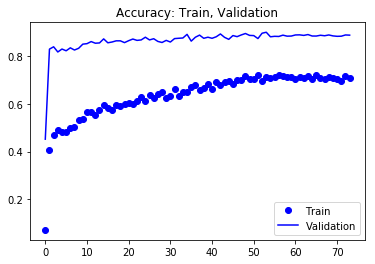

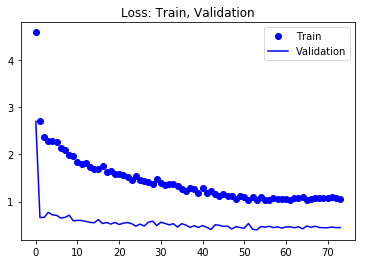

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [30]:
parallel_model.save('./models/model_InceptionResNetV2_RAdam.h5')

# Predict

In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 3025 images belonging to 120 classes.


In [32]:
probabilities = parallel_model.predict_generator(test_generator)

In [33]:
# Get Max Index
predicted_class_index=np.argmax(probabilities,axis=1)

# Dictionary: Index to Class
class_labels = list(test_generator.class_indices.keys())
index_to_labels = dict((v,k) for k,v in test_generator.class_indices.items())

# Get List of Predictions
predictions = [index_to_labels[ix] for ix in predicted_class_index]

# Get Dictionary of Predictions
results=pd.DataFrame({"Filename":test_generator.filenames,
                      "Predictions":predictions})

In [34]:
results.head()

,Filename,Predictions
0,n02085620-Chihuahua\n02085620_10074.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua\n02085620_10131.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua\n02085620_10621.jpg,n02085620-Chihuahua
3,n02085620-Chihuahua\n02085620_1073.jpg,n02085620-Chihuahua
4,n02085620-Chihuahua\n02085620_10976.jpg,n02085620-Chihuahua


In [40]:
results.to_csv("./models/results_details_InceptionResNetV2.csv", sep="|", index=False)

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels, predicted_class_index)

In [36]:
results_dict = {}
tp_sum, fp_sum = 0, 0

for ix, row in enumerate(cm):
    
    tp = row[ix]
    fp = np.sum(row) - tp   
    results_dict[ix] = [class_labels[ix],tp,fp,(tp/(tp+fp)*100)]

    tp_sum += tp
    fp_sum += fp
    
df_res = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Class","True Positive","False Positive","Accuracy"])

print("General Accuracy:{:0.2f}".format(tp_sum/(tp_sum+fp_sum)))

General Accuracy:0.89


In [37]:
df_res.head()

,Class,True Positive,False Positive,Accuracy
0,n02085620-Chihuahua,20,2,90.909091
1,n02085782-Japanese_spaniel,25,2,92.592593
2,n02085936-Maltese_dog,34,3,91.891892
3,n02086079-Pekinese,20,2,90.909091
4,n02086240-Shih-Tzu,29,3,90.625000


In [39]:
df_res.to_csv("./models/results_InceptionResNetV2.csv", sep="|", index=False)